In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from adjustText import adjust_text

In [2]:
data = pd.read_stata("EPI_CPS_data/epi_cpsbasic_2024.dta")[["year","occ18","wage","orgwgt","dind03"]]
data["dind03"] = data["dind03"].astype(str).str.strip().str.lower()
data["occ18"] = data["occ18"].astype(str).str.strip().str.lower()
clean_mask = data["wage"].notna() & data["orgwgt"].notna() & (data["occ18"] != -1) & (data["year"] == 2024)
data = data[clean_mask].copy().reset_index()
data.pop('index')

data['occ18'].value_counts()

occ18
managers, all other                                3582
registered nurses                                  3156
elementary and middle school teachers              3153
driver/sales workers and truck drivers             2685
cashiers                                           2140
                                                   ... 
podiatrists                                           4
tire builders                                         4
acupuncturists                                        3
etchers and engravers                                 2
other textile, apparel, and furnishings workers       2
Name: count, Length: 525, dtype: int64

In [3]:
# Weighted counts of occupation–industry pairs
weights = (
    data.groupby(['occ18', 'dind03'])['orgwgt']
        .sum()
        .reset_index(name='total_weight')
)

# For each occupation, pick the industry with the highest weight
dominant_industry = (
    weights.sort_values('total_weight', ascending=False)    # sort by descending total weight
           .drop_duplicates(subset='occ18')                 # drop all but first occurence
           .loc[:, ['occ18', 'dind03']]                     # remove totalweight column
           .rename(columns={'dind03': 'industry'})          # rename to 'industry'
)

dominant_industry

,occ18,industry
2031,elementary and middle school teachers,educational services
6067,retail salespersons,retail trade
2683,first-line supervisors of retail sales workers,retail trade
6013,registered nurses,hospitals
1349,construction laborers,construction
...,...,...
985,compensation and benefits managers,public administration
4892,"other machine tool setters, operators, and ten...",petroleum and coal products manufacturing
6826,telephone operators,hospitals
190,animal control workers,personal and laundry services


In [4]:
def weighted_mean(x):
    return np.average(x['wage'], weights=x['orgwgt'])

def weighted_var(x):
    mean = weighted_mean(x)
    return np.average((x['wage'] - mean)**2, weights=x['orgwgt'])

grouped_data = data.groupby("occ18").apply(lambda x: pd.Series({'mean_wage': weighted_mean(x), 'var_wage': weighted_var(x)})).reset_index()
grouped_data = grouped_data.merge(right=dominant_industry, on='occ18')
unsliced_data = grouped_data.copy()
grouped_data

/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_50293/832494828.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data = data.groupby("occ18").apply(lambda x: pd.Series({'mean_wage': weighted_mean(x), 'var_wage': weighted_var(x)})).reset_index()


,occ18,mean_wage,var_wage,industry
0,accountants and auditors,48.348270,1263.052612,professional and technical services
1,actors,47.068478,4225.178711,"arts, entertainment, and recreation"
2,actuaries,76.705605,2606.519531,insurance
3,acupuncturists,21.665100,50.176628,"health care services, except hospitals"
4,adhesive bonding machine operators and tenders,24.342443,43.094505,wood products
...,...,...,...,...
520,"welding, soldering, and brazing workers",26.425755,130.142502,repair and maintenance
521,"wholesale and retail buyers, except farm products",33.383827,906.026367,retail trade
522,"woodworking machine setters, operators, and te...",19.102880,37.251286,furniture and fixtures manufacturing
523,word processors and typists,23.103712,55.872284,public administration


In [5]:
unsliced_data["industry"].value_counts()

industry
professional and technical services                  74
health care services, except hospitals               46
public administration                                46
transportation and warehousing                       35
construction                                         34
retail trade                                         33
educational services                                 21
administrative and support services                  18
hospitals                                            18
personal and laundry services                        16
arts, entertainment, and recreation                  16
repair and maintenance                               16
finance                                              14
food services and drinking places                    12
primary metals and fabricated metal products         12
transportation equipment manufacturing               10
membership associations and organizations             9
food manufacturing                     

In [7]:
# 1. Prepare data for regression
X = sm.add_constant(grouped_data['var_wage'])
y = grouped_data['mean_wage']
model = sm.OLS(y, X).fit()

# 2. Predicted (fitted) line
grouped_data['predicted_mean'] = model.predict(X)
print(model.summary())

# Regression line
def y_fitted(x):
    return model.params[0] + model.params[1] * x
x_sorted = np.linspace(grouped_data['var_wage'].min(), grouped_data['var_wage'].max(), 100)

                            OLS Regression Results                            
Dep. Variable:              mean_wage   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     1505.
Date:                Tue, 02 Dec 2025   Prob (F-statistic):          5.17e-156
Time:                        10:18:36   Log-Likelihood:                -1798.3
No. Observations:                 525   AIC:                             3601.
Df Residuals:                     523   BIC:                             3609.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.0247      0.402     62.271      0.0

/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_50293/2588081134.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[0] + model.params[1] * x


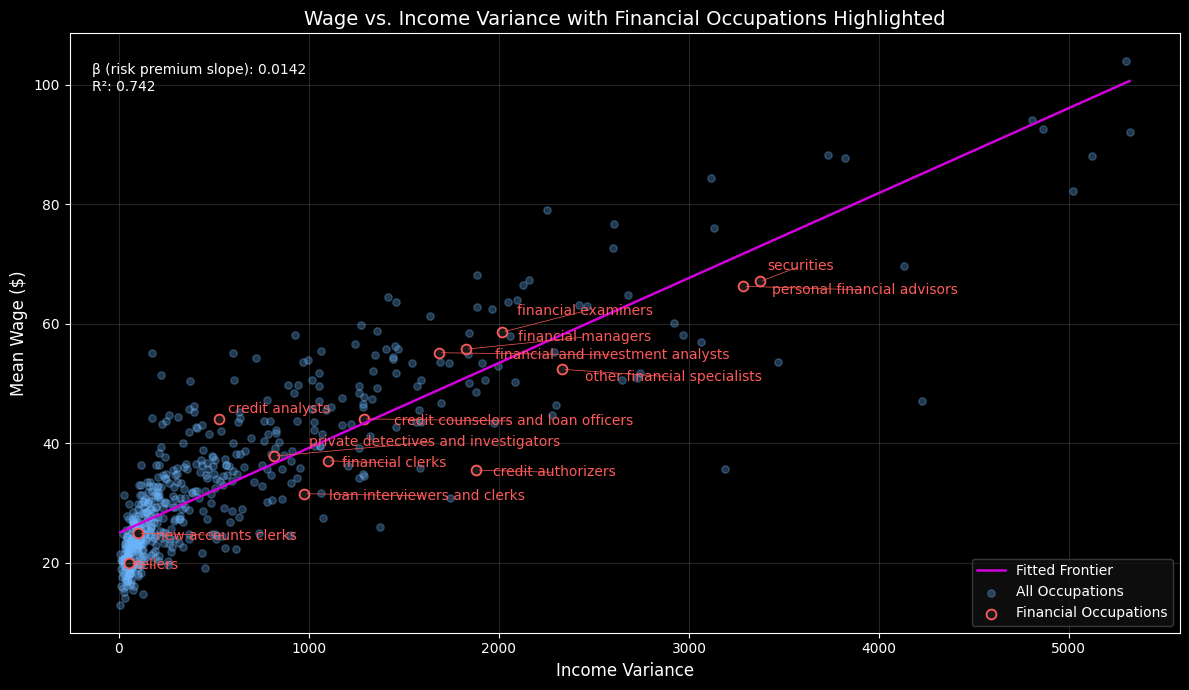

In [ ]:
plt.style.use("dark_background")

# Colors
highlight_edge = "#FE5A5A"
highlight_face = '#1A1A1A'
muted_color    = "#6EB7FF"
line_color     = "#D100DC"

# Fit stats
beta = model.params['var_wage']
r2 = model.rsquared

# Slice data
financial_mask = grouped_data["industry"]=="finance"
fin_data = grouped_data[financial_mask]
nonfin_data = grouped_data[~financial_mask]

# Plot
plt.figure(figsize=(12, 7))

# Regression line
plt.plot(x_sorted, y_fitted(x_sorted), color=line_color, lw=1.8, label='Fitted Frontier')

# Non-financial occupations
plt.scatter(nonfin_data['var_wage'], nonfin_data['mean_wage'],
            alpha=0.3, s=28, color=muted_color, label='All Occupations')

# Highlighted financial occupations
plt.scatter(fin_data['var_wage'], fin_data['mean_wage'],
            s=50, edgecolor=highlight_edge, facecolor=highlight_face,
            linewidth=1.3, label='Financial Occupations')


# Clean labels with offset + truncation
texts = []
for _, row in fin_data.iterrows():
    short_label = row["occ18"].split(",")[0]
    t = plt.text(row['var_wage'], row['mean_wage'], short_label,
                 fontsize=10, color=highlight_edge)
    texts.append(t)


# --- ADJUST TEXT ---
adjust_text(
    texts,
    expand_points=(1.0, 5.0),         # stronger repulsion
    expand_text=(1.3, 1.3),
    only_move={'points':'y', 'text':'y'},   # allow y movement only
    arrowprops=dict(arrowstyle="-", color=highlight_edge, lw=0.5)
)

# Annotate model stats
plt.text(0.02, 0.95,
         f"β (risk premium slope): {beta:.4f}\nR²: {r2:.3f}",
         transform=plt.gca().transAxes,
         fontsize=10,
         color='#FFFFFF',
         verticalalignment='top')

# Axis & title
plt.xlabel("Income Variance", fontsize=12)
plt.ylabel("Mean Wage ($)", fontsize=12)
plt.title("Wage vs. Income Variance with Financial Occupations Highlighted", fontsize=14)

plt.legend(facecolor="#111111", edgecolor="#444444")
plt.grid(alpha=0.15)
plt.tight_layout()
plt.show()

/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_50293/2588081134.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return model.params[0] + model.params[1] * x
/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_50293/2460011373.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tilt_scores = pruned_data.groupby("industry").apply(compensation_tilt_score)
/var/folders/hb/clzbwtq527b2g9qfk2dhk1yr0000gn/T/ipykernel_50293/2460011373.py:30: FutureWarning: 

Passing `palette` without assigning `hue` 

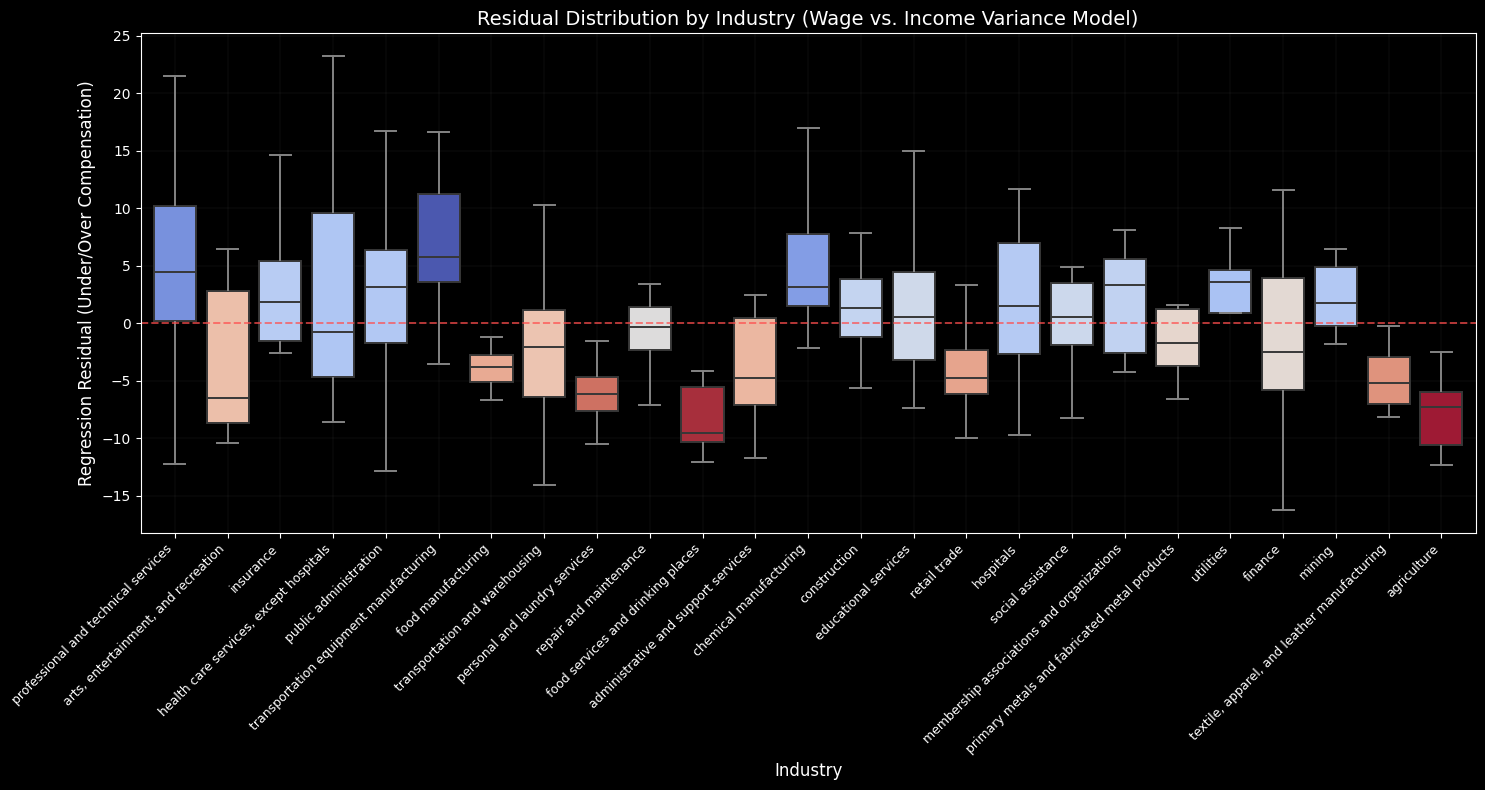

In [88]:
grouped_data["residuals"] = grouped_data["mean_wage"] - y_fitted(grouped_data["var_wage"])

# Compute IQR & count per industry
stats = grouped_data.groupby("industry")["residuals"].agg(
    q1=lambda x: x.quantile(0.25),
    q3=lambda x: x.quantile(0.75),
    count='count'
)
stats["IQR"] = stats["q3"] - stats["q1"]

# Filter main dataframe
valid_industries = stats[(stats["IQR"] >= 2) & (stats["count"] >= 4)].index
pruned_data = grouped_data[grouped_data["industry"].isin(valid_industries)]

def compensation_tilt_score(group):
    q1 = group['residuals'].quantile(0.25)
    q3 = group['residuals'].quantile(0.75)
    return (q1 + q3) / 2

tilt_scores = pruned_data.groupby("industry").apply(compensation_tilt_score)

# Custom dark palette for diverging residuals
# Blue for over-compensation, red for under-compensation
norm = plt.Normalize(vmin=tilt_scores.values.min(), vmax=tilt_scores.values.max())
cmap = plt.cm.coolwarm_r
industry_colors = {ind: cmap(norm(val)) for ind, val in tilt_scores.items()}

plt.style.use("dark_background")
plt.figure(figsize=(15, 8))
sns.boxplot(
    data=pruned_data,
    x='industry',
    y='residuals',
    palette=industry_colors,
    showfliers=False,
    linewidth=1.4,
    whiskerprops=dict(color="#848484"),
    capprops=dict(color='#848484'),
)

# Zero line with brighter contrast
plt.axhline(y=0, color='#FF4D4D', linestyle='--', lw=1.4, alpha=0.7)

# Axis labels / title in slightly brighter text
plt.xlabel('Industry', fontsize=12, color='white')
plt.ylabel('Regression Residual (Under/Over Compensation)', fontsize=12, color='white')
plt.title('Residual Distribution by Industry (Wage vs. Income Variance Model)',
          fontsize=14, color='white')

# Rotate x labels
plt.xticks(rotation=45, ha='right', fontsize=9, color='white')

# Dark grid with low alpha for subtle structure
plt.grid(color='gray', linestyle='-', linewidth=0.3, alpha=0.25)
plt.margins(x=0.01)

plt.tight_layout()
plt.show()